In [1]:
# Loading the dataset function

from dataset_functions import *
from RGB_functions import *
%matplotlib inline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading Dataset

dataset_path = r"/home/arbash44/coding/hsi/PCBDataset/"
#HSI, HSI_general_masks, HSI_monoseg_masks, RGB, RGB_monoseg_masks, RGB_general_masks, PCB_Masks = read_dataset(dataset_path)
_, _, _, RGB, RGB_ramses_masks, RGB_general_masks, _ = read_dataset(dataset_path)

  0%|          | 0/53 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
100%|██████████| 53/53 [00:03<00:00, 14.57it/s]

Dataset loading is complete.


In [3]:
# Data Split
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
images_train, images_test, masks_train, masks_test = train_test_split(RGB, RGB_general_masks, test_size=0.2, random_state=123)

# Split the training set into training and validation sets
images_train, images_validation, masks_train, masks_validation = train_test_split(images_train, masks_train, test_size=0.2, random_state=123)

# Print the lengths of the training, validation, and test sets
print(len(images_train), len(images_validation), len(images_test))

33 9 11


In [4]:
# Calculate the mean and standard deviation of the training data
mean, std = calculate_mean_std(images_train)

# Print the calculated mean and standard deviation
print("Mean:", mean)
print("Standard deviation:", std)

Mean: (50.077636570785984, 42.78071185487689, 31.043130696614583)
Standard deviation: (9.793301347906903, 8.75593220074957, 5.798582206675301)


In [ ]:
import albumentations as A

# Define the data augmentation pipeline
transform = A.Compose(
    [

        # Randomly flip the images horizontally or vertically
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),

        # Randomly rotate the images by up to 40 degrees
        A.Rotate(limit=40, border_mode=cv2.BORDER_CONSTANT, p=0.4),

        # Randomly rotate the images by up to -40 degrees
        A.Rotate(limit=-40, border_mode=cv2.BORDER_CONSTANT, p=0.4),

        # Randomly shift the RGB values of each pixel
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.4),

        # Apply random brightness, contrast, saturation, and hue adjustments
        A.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.4, hue = 0.2, p = .4),

        # Randomly shuffle the channels of the image
        A.ChannelShuffle(p=0.4),

        # Randomly transpose the image dimensions (swap rows and columns)
        A.Transpose(p=0.4),

        # Add random snow effects to the image
        A.RandomSnow(p=0.4),

        # Randomly shift, scale, and rotate the image while preserving aspect ratio
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=.4, border_mode=0),

        # Perform one of the following operations:
        #   - Apply random brightness adjustments
        #   - Apply random gamma adjustments
        A.OneOf([
            A.RandomBrightness(p=1),
            A.RandomGamma(p=1),
        ], p=0.4),

        # Perform one of the following operations:
        #   - Apply random blur of up to 3 pixels
        #   - Apply random motion blur of up to 3 pixels
        A.OneOf([
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ], p=0.4),

        # Perform one of the following operations:
        #   - Apply random contrast adjustments
        #   - Apply random hue, saturation, and value adjustments
        A.OneOf([
            A.RandomContrast(p=1),
            A.HueSaturationValue(p=1),
        ], p=0.4),
    ],
)

In [6]:
def augment_training(images, masks, n=13):
    """
    Augment training images and masks a given number of times.

    Parameters:
        images (list): List of training images.
        masks (list): List of training masks.
        n (int, optional): Number of times to augment each image-mask pair. Default: 13.

    Returns:
        list: Augmented training images.
        list: Augmented training masks.
    """

    # Initialize empty lists to store augmented data
    aug_images = []
    aug_masks = []

    # Augment each image-mask pair multiple times
    for i in range(len(images)):
        # Add the original image and mask to the augmented sets
        aug_images.append(images[i])
        aug_masks.append(masks[i])

        for _ in range(n):
            # Apply the data augmentation pipeline to the image and mask
            transformed = transform(image=images[i], mask=masks[i])

            # Append the augmented image and mask to the respective lists
            aug_images.append(transformed['image'])
            aug_masks.append(transformed['mask'])

    return aug_images, aug_masks

In [7]:
# Data Augmentation - Train only
training_images, training_masks = augment_training(images_train, masks_train)
print('Total Training Images After Augmentations: {}'.format(len(training_images)))
print('Total Training Masks After Augmentations: {}'.format(len(training_masks)))
print('\n')

print('Total Training Images After Augmentations: {}'.format(len(images_validation)))
print('Total Training Masks After Augmentations: {}'.format(len(masks_validation)))

Total Training Images After Augmentations: 462
Total Training Masks After Augmentations: 462


Total Training Images After Augmentations: 9
Total Training Masks After Augmentations: 9


(-0.5, 529.5, 1606.5, -0.5)

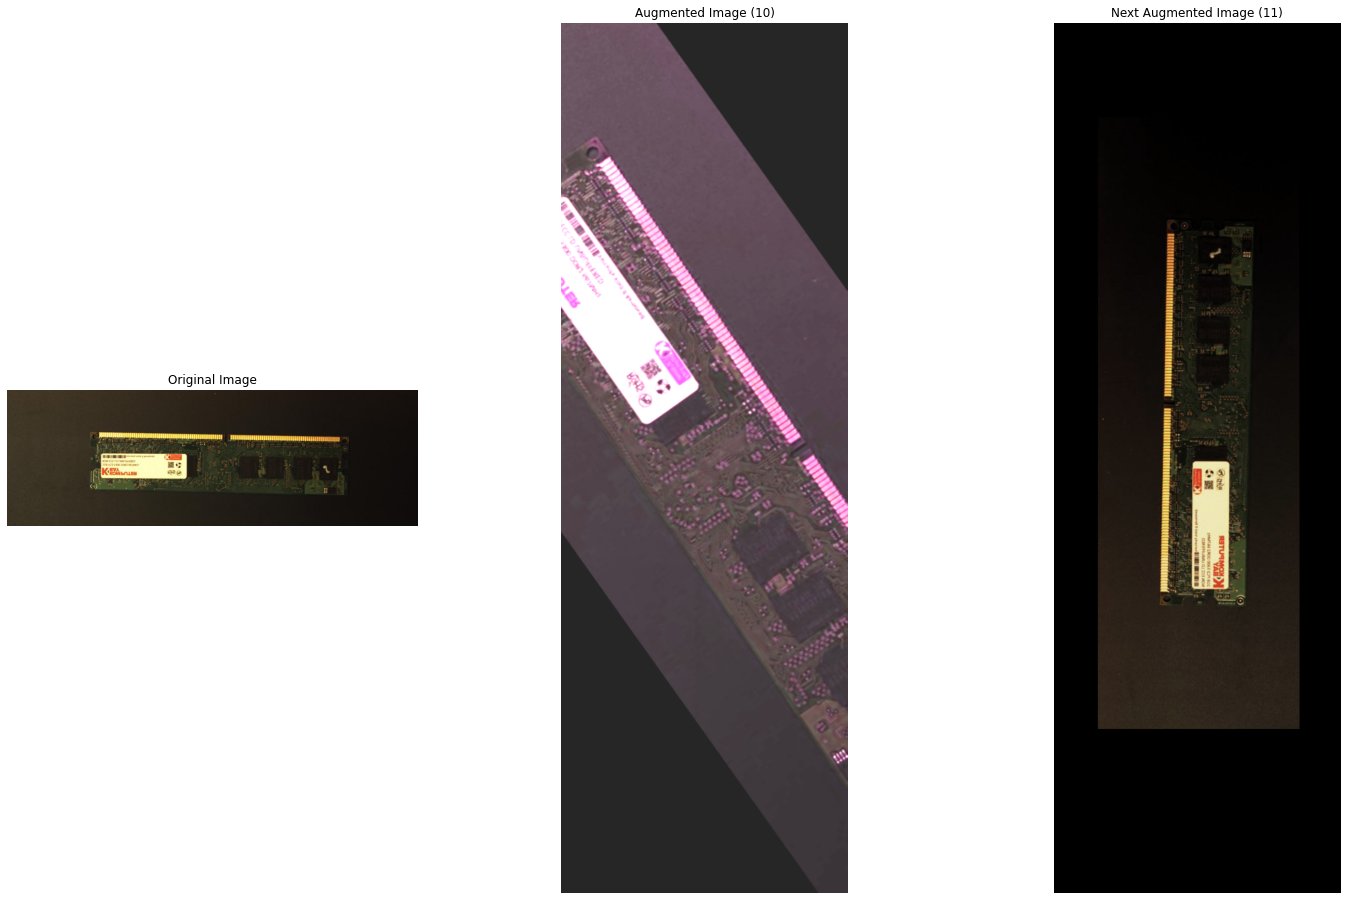

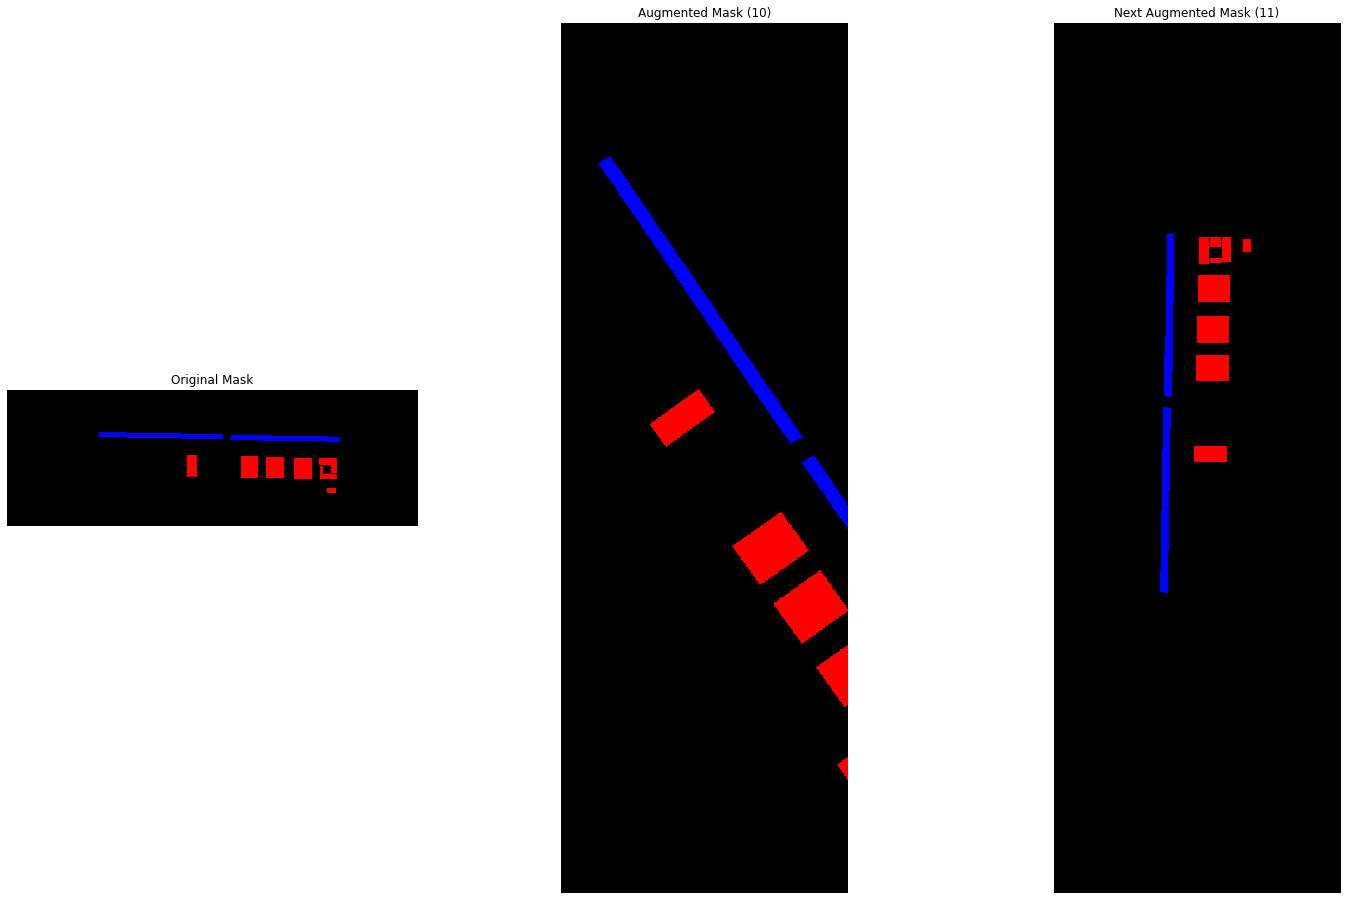

In [8]:
# Select specific images and masks to visualize
i = 10  # Index of the first image to visualize

# Display the original image and mask
plt.figure(figsize=(25, 16))  # Set figure size

plt.subplot(1, 3, 1)  # Create subplot 1
plt.imshow(training_images[0])  # Display the first training image
plt.title('Original Image')  # Add a title
plt.axis('off')  # Hide axis

plt.subplot(1, 3, 2)  # Create subplot 2
plt.imshow(training_images[i])  # Display the selected training image
plt.title('Augmented Image ({})'.format(i))  # Add a title
plt.axis('off')  # Hide axis

plt.subplot(1, 3, 3)  # Create subplot 3
plt.imshow(training_images[i + 1])  # Display the next training image
plt.title('Next Augmented Image ({})'.format(i+1))  # Add a title
plt.axis('off')  # Hide axis

# Display the original mask and two augmented masks
plt.figure(figsize=(25, 16))  # Set figure size

plt.subplot(1, 3, 1)  # Create subplot 1
visualize(training_masks[0])  # Display the first training mask
plt.title('Original Mask')  # Add a title
plt.axis('off')  # Hide axis

plt.subplot(1, 3, 2)  # Create subplot 2
visualize(training_masks[i])  # Display the selected training mask
plt.title('Augmented Mask ({})'.format(i))  # Add a title
plt.axis('off')  # Hide axis

plt.subplot(1, 3, 3)  # Create subplot 3
visualize(training_masks[i + 1])  # Display the next training mask
plt.title('Next Augmented Mask ({})'.format(i+1))  # Add a title
plt.axis('off')  # Hide axis


In [9]:
len(training_images)

462

In [10]:
import torchvision.transforms as transforms

img_res = 640

class CustomDataset(Dataset):
    """
    Custom dataset class for loading image and mask data.

    Parameters:
        images (list): List of images.
        masks (list): List of corresponding masks.
        transform (torchvision.transforms.Compose): Image transformation pipeline.
        transform_mask (bool): Masks transformation pipeline.
        num_classes (int): Number of segmentation classes.
    """

    def __init__(self, images, masks, transform=None, transform_mask=False, num_classes=3):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.transform_mask = transform_mask
        self.num_classes = num_classes

    def __len__(self):
        """Return the length of the dataset."""
        return len(self.images)

    def __getitem__(self, index):
        """Load and preprocess an image and its corresponding mask."""
        image = self.images[index]
        mask = self.masks[index]

        # Apply transformations if specified
        if self.transform:
            # Convert NumPy img to PIL Image
            image = Image.fromarray(image)            
            # Image resizing
            image = self.transform(image)
            
            # Apply standardization
            image = np.array(image)
            image = image.transpose(1, 2, 0).astype('float32') # 800,800,3
            image = (image - mean) / std
            image = image.transpose(2, 0, 1).astype('float32') # 3,800,800,

        # Convert mask to one-hot encoded format
        if self.transform_mask:
            # Convert NumPy img to PIL Image
            mask = Image.fromarray(mask)
            # Mask resizing
            mask = self.transform_mask(mask)
            
            # Making mask dimension suitable for training like images
            mask = np.array(mask)
            mask = np.expand_dims(mask, axis=0)
            mask = torch.as_tensor(mask, dtype=torch.long)

        return image, mask

# Define image resizing transformations
transform = transforms.Compose([
    transforms.Resize((img_res, img_res), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),  # Converts the image and mask to PyTorch tensors
])

transform2 = transforms.Compose([
    transforms.Resize((img_res, img_res), interpolation=transforms.InterpolationMode.NEAREST),
])

In [11]:
from torchvision import transforms
from models.Unet import UNET
# from models.Unet_Attention import AttU_Net
# from models.ResUnet import ResUnet

device = set_gpu(1)

# Set up the hyperparameters and configuration
num_classes = 4  # Number of output classes
batch_size = 8  # Batch size for training
learning_rate = 0.0001  # Learning rate for the optimizer
num_epochs = 40  # Number of training epochs

# Define class weights to handle class imbalance
class_weights = [.1, .8, .85, .9]  # Weights for each class
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Convert weights to tensors and move to device

# Call the DL model
model = UNET(in_channels = 3, out_channels = num_classes) # Specify input (input = Principal Component) and output channels
# model = AttU_Net(img_ch=3,output_ch=num_classes)
# model = ResUnet(channel=3,out_channel=num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')  # Use the class weights in the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Use Adam optimizer with specified learning rate

# Prepare your training and validation sets
train_dataset = CustomDataset(
    training_images, 
    training_masks,
    num_classes = num_classes,
    transform = transform,
    transform_mask = transform2,
)

valid_dataset = CustomDataset(
    images_validation, 
    masks_validation, 
    num_classes = num_classes,
    transform = transform,
    transform_mask = transform2,
)

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

# Specify the path to the pre-trained weights file: Change according to the chosen model !!
path = 'RGB_unet.pth'

In [12]:
model

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

## Training phase

In [ ]:
# Training loop
best_epoch = 0
best_val_loss = float('inf')

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Iterate over the training batches
    for images, masks in train_loader:
        optimizer.zero_grad()

        # Move the data to GPU
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.to(device)

        # Remove the channel dimension from masks
        masks = torch.squeeze(masks, dim=1)
        
        # To make the masks have same shape and style as the output of the model
        masks = torch.nn.functional.one_hot(masks, num_classes)
        masks = masks.permute(0, 3, 1, 2)
        #images = images.permute(0, 3, 1, 2)
        masks = masks.type(torch.FloatTensor)
        
        # Forward pass
        outputs = model(images)
        # Move masks to the same device as outputs
        masks = masks.to(outputs.device)
        # Compute the loss
        loss = criterion(outputs, masks)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print the average training loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}")

    # Perform validation after each epoch
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in valid_loader:
            # Move the data to GPU
            images = images.to(device)
            masks = masks.type(torch.LongTensor)
            masks = masks.to(device)

            # Remove the channel dimension from masks
            masks = torch.squeeze(masks, dim=1)
            
            # To make the masks have same shape and style as the output of the model
            masks = torch.nn.functional.one_hot(masks, num_classes)
            masks = masks.permute(0, 3, 1, 2)
            #images = images.permute(0, 3, 1, 2)
            masks = masks.type(torch.FloatTensor)

            # Forward pass
            outputs = model(images)
            # Move masks to the same device as outputs
            masks = masks.to(outputs.device)

            # Compute the loss
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    # Print the average validation loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss / len(valid_loader):.4f}")

    # Check if current epoch has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        # Save the weights of the best epoch
        torch.save(model.state_dict(), path)
        print('Model Saved! , Best Val Loss so far = {}'.format(best_val_loss/ len(valid_loader)))
# Print the best epoch and corresponding validation loss
print(f"Best Epoch: {best_epoch + 1}, Best Validation Loss: {best_val_loss:.4f}")

## Testing phase

In [17]:
# Prepare your testing data
test_dataset = CustomDataset(
    images_test, 
    masks_test, 
    num_classes = num_classes,
    transform = transform,
    transform_mask = transform2,
    )
# Create data loaders for each set
test_loader = DataLoader(test_dataset, batch_size=1, pin_memory=True)

In [18]:
# Load the trained weights
model.load_state_dict(torch.load(path))

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model in evaluation mode
model.eval()

# Initialize lists to store predicted masks
predicted_masks = []

# Iterate over the test images and their ground truth masks
for images, masks in test_loader:
    # Move the data to GPU
    images = images.to(device)  # Transfer the image data to the specified device
    masks = masks.type(torch.LongTensor)  # Convert the ground truth masks to LongTensor format
    masks = masks.to(device)  # Transfer the ground truth masks to the specified device

    # Remove the channel dimension from masks: Flatten the masks to remove the channel dimension
    masks = torch.squeeze(masks, dim=1)
            
    # To make the masks have same shape and size as the output of the model
    masks = torch.nn.functional.one_hot(masks, num_classes)  # Convert the masks to one-hot encodings
    masks = masks.permute(0, 3, 1, 2)  # Transpose the masks to match the expected output shape
    #images = images.permute(0, 3, 1, 2)  # Transpose the images to match the expected input shape
    masks = masks.type(torch.FloatTensor)  # Convert the masks to FloatTensor format
    
    # Perform inference
    with torch.no_grad():  # Forward pass the images through the model to obtain the predictions
        output = model(images)  # Forward pass the images through the model to obtain the predictions 

    # Remove batch dimension
    output = torch.squeeze(output, dim=0)  # (1, 4, 640, 640) --> (4, 640, 640)
    output = torch.nn.functional.softmax(output, dim=0)
    output = torch.argmax(output, dim=0)#.squeeze(0)
    
    # Transfer the output to CPU memory and convert it to a numpy array
    predicted_mask = output.cpu().numpy()
    # Append the predicted mask to the list
    predicted_masks.append(predicted_mask)

In [19]:
# Size & Dimension Checks
len(predicted_masks),len(masks_test), predicted_masks[0].shape, masks_test[0].shape

(11, 11, (640, 640), (2518, 3365))

(-0.5, 3364.5, 2517.5, -0.5)

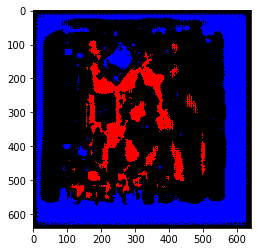

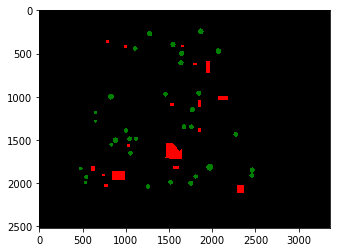

In [20]:
visualize(predicted_masks[0])
plt.axis('on')
plt.figure()
visualize(masks_test[0])
plt.axis('on')

## Evaluation phase

In [21]:
# Resize predicted masks to original shape
predicted_masks2 = []

for i, m in enumerate(predicted_masks):
    """
    Resize each predicted mask to the original size of its corresponding ground truth mask.

    Parameters:
        i (int): Index of the current mask
        m (numpy.ndarray): Predicted mask
        Testing_masks[i] (numpy.ndarray): Corresponding ground truth mask
    """

    # Resize the predicted mask using the dimensions of the ground truth mask
    predicted_masks2.append(resize_segmentation_masks(m, masks_test[i].shape))

print(predicted_masks2[0].shape, masks_test[0].shape)  # Print the shape of the resized and original masks

(2518, 3365) (2518, 3365)


(-0.5, 3364.5, 2517.5, -0.5)

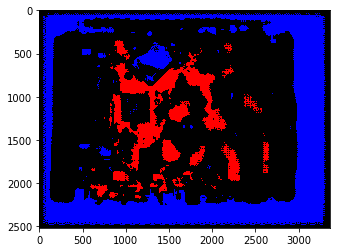

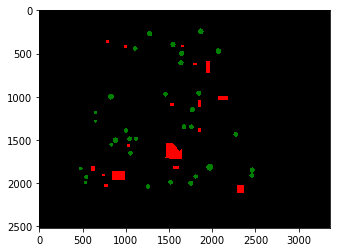

In [22]:
visualize(predicted_masks2[0])
plt.axis('on')
plt.figure()
visualize(masks_test[0])
plt.axis('on')

In [ ]:
# Convert the list to a numpy array
predicted_masks2 = np.array(predicted_masks2)

# Call the evaluate_segmentation function
confusion_matrix_sum, true_positive_sum, true_negative_sum, false_positive_sum, false_negative_sum, precision, recall, f1_score, pixel_accuracy_per_class, pixel_accuracy, iou, dice_coefficient, kappa = evaluate_segmentation(masks_test, predicted_masks2, num_classes)

# Print the evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix_sum)
print("Pixel Accuracy:")
print(pixel_accuracy)
print("Precision:")
print(precision)
print("Recall:")
print(recall)
print("F1 Score:")
print(f1_score)
print("Intersection over Union (IoU):")
print(iou)
print("Dice Coefficient:")
print(dice_coefficient)
print("Kappa Coefficient:")
print(kappa)
